In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import Experiment, RestartingExperiment

In [3]:
data = pd.read_csv("../../../sonar.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:
X = data.loc[:, data.columns[:-1]].values
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
y = data.loc[:, data.columns[-1]]
y = np.where(y == "R", 1, -1)

X = torch.tensor(X)
y = torch.tensor(y)

X.shape, y.shape

(torch.Size([208, 61]), torch.Size([208]))

In [5]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
model = LogisticRegressionGD(X_train, y_train, 1e-2)

In [7]:
model.fit(1e-4, max_iter=1000000)

In [8]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.8095, dtype=torch.float64)

In [9]:
len(model.log)

24701

## Without restarting

In [10]:
experiment = Experiment(model.log, model.obj, values=model.value_log)
k = 6

In [11]:
experiment.run_method("VLT", h_algorithm, k+1, method_kwargs={"k": k, "type": "t"})

In [12]:
experiment.run_method("VLU", h_algorithm, k+1, method_kwargs={"k": k, "type": "u"})

In [13]:
experiment.run_method("VLV", h_algorithm, k+2, method_kwargs={"k": k, "type": "v"})

In [14]:
experiment.run_method("SLT", e_algorithm, k+1, method_kwargs={"k": k, "type": "t"})

In [15]:
experiment.run_method("SLU", e_algorithm, k+1, method_kwargs={"k": k, "type": "u"})

In [16]:
experiment.run_method("SLV", e_algorithm, k+2, method_kwargs={"k": k, "type": "v"})

In [17]:
experiment.run_method("RRE+QR", RRE, k, method_kwargs={"qr": True})

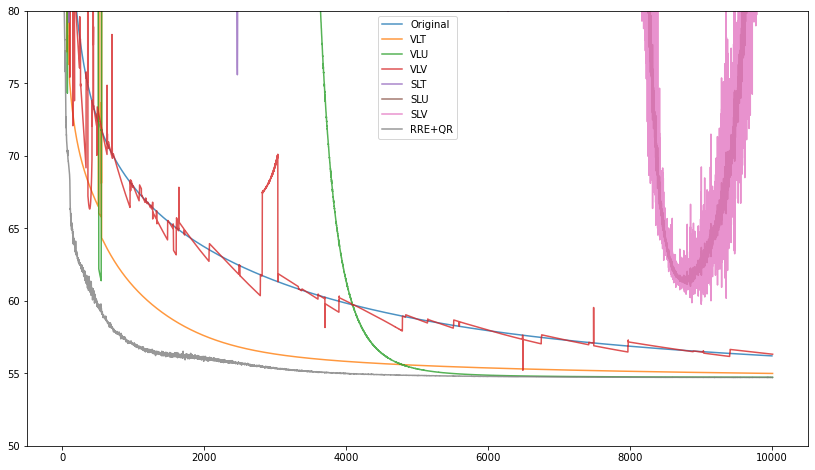

In [18]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000)
plt.ylim(50, 80)
plt.legend()

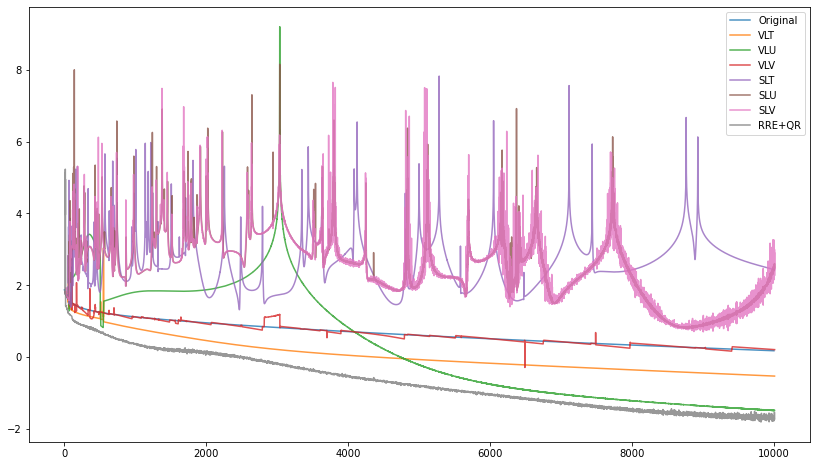

In [19]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000)
plt.legend()

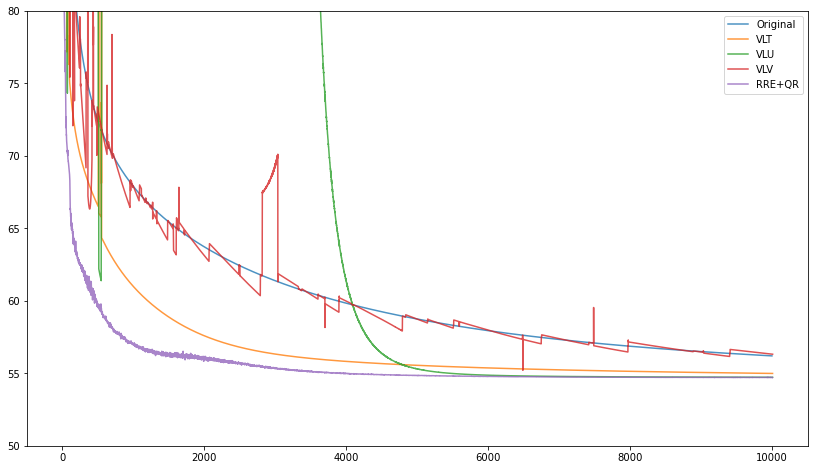

In [20]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VLT", "VLU", "VLV", "RRE+QR"])
plt.ylim(50, 80)
plt.legend()         

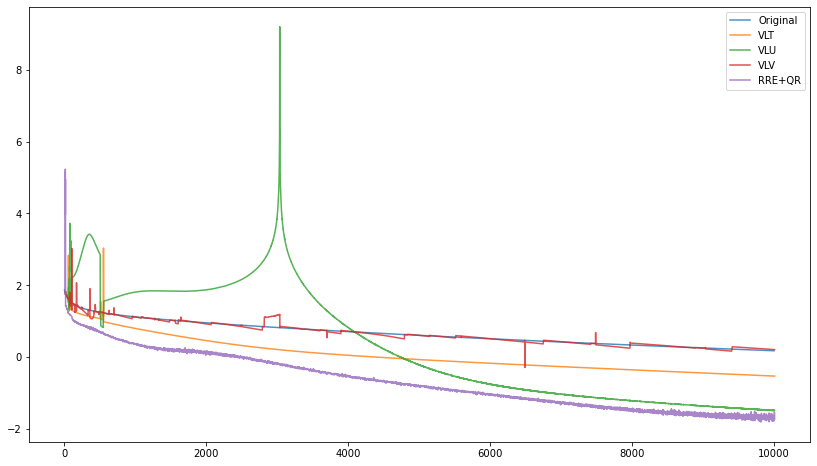

In [21]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VLT", "VLU", "VLV", "RRE+QR"])
plt.legend()    

In [22]:
model.theta = experiment.best_x
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.8095, dtype=torch.float64)

In [23]:
df = experiment.value_df()
df.to_csv("results/sonar-levin.csv")

## With restarting

In [24]:
experiment = RestartingExperiment(model)
k = 6

In [25]:
experiment.run_method("VLT", h_algorithm, k+1, 5000, method_kwargs={"k": k, "type": "t"})

In [26]:
experiment.run_method("VLU", h_algorithm, k+1, 5000, method_kwargs={"k": k, "type": "u"})

In [27]:
experiment.run_method("VLV", h_algorithm, k+2, 5000, method_kwargs={"k": k, "type": "v"})

In [28]:
experiment.run_method("SLT", e_algorithm, k+1, 5000, method_kwargs={"k": k, "type": "t"})

In [29]:
experiment.run_method("SLU", e_algorithm, k+1, 5000, method_kwargs={"k": k, "type": "u"})

In [30]:
experiment.run_method("SLV", e_algorithm, k+2, 5000, method_kwargs={"k": k, "type": "v"})

In [31]:
experiment.run_method("RRE+QR", RRE, k, 5000, method_kwargs={"qr": True})

In [32]:
experiment.run_method("MMPE", MMPE, k, 5000)

In [33]:
experiment.run_method("Epsilon inv", vector_epsilon_v1, 2*k, 5000, method_kwargs={"k": k})

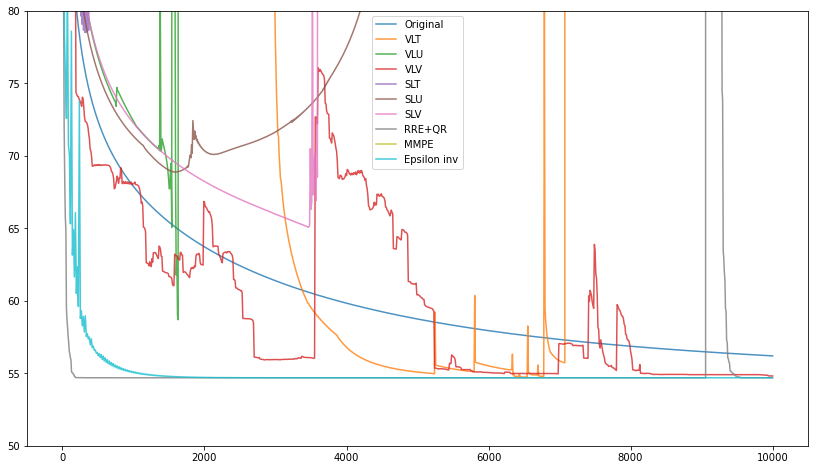

In [34]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000)
plt.ylim(50, 80)
plt.legend()

../../experiments.py:72: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(np.array(self.value_logs[m][:len(x)]) - best)),


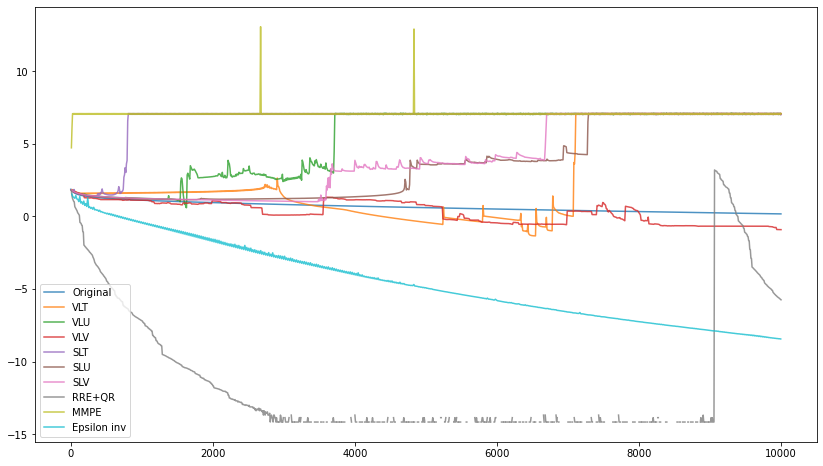

In [35]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000)
plt.legend()

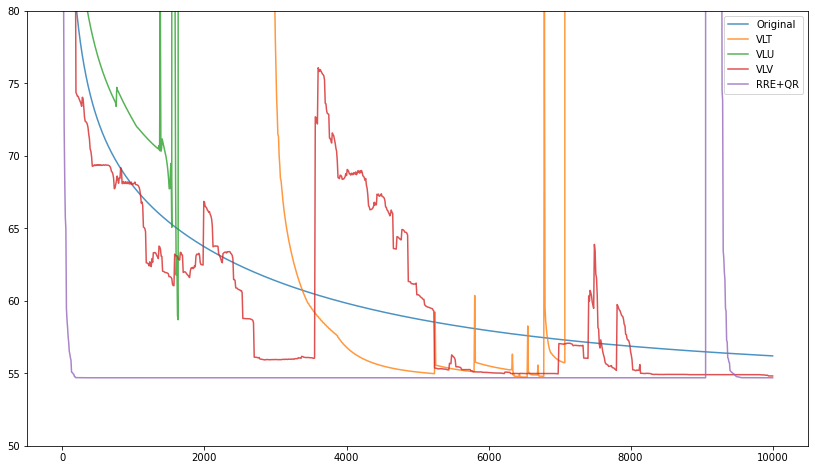

In [36]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["VLT", "VLU", "VLV", "RRE+QR"])
plt.ylim(50, 80)
plt.legend()         

../../experiments.py:72: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(np.array(self.value_logs[m][:len(x)]) - best)),


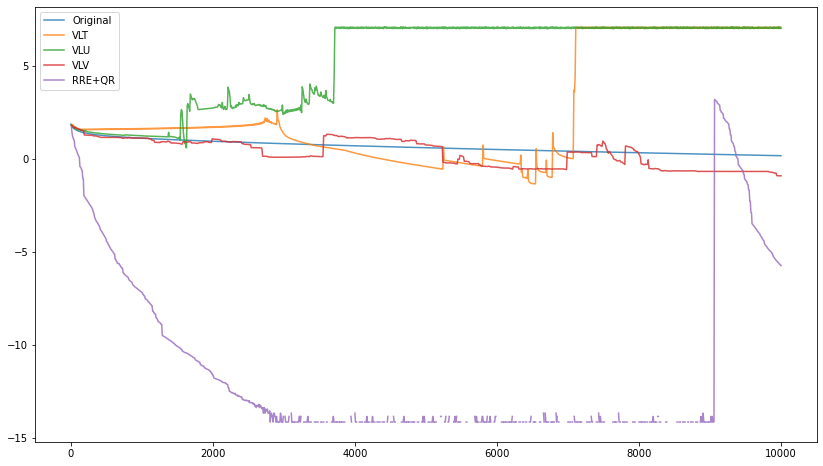

In [37]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["VLT", "VLU", "VLV", "RRE+QR"])
plt.legend()    

In [38]:
model.theta = experiment.best_x
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.8095, dtype=torch.float64)

In [39]:
df = experiment.value_df()
df.to_csv("results/sonar-levin-restarts.csv")